#  Прогнозирование заказов такси

Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Требование:
* Метрика *RMSE* на тестовой выборке <= 48.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Добавление-новых-признаков" data-toc-modified-id="Добавление-новых-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Добавление новых признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Заключение" data-toc-modified-id="Заключение-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Заключение</a></span></li></ul></li><li><span><a href="#Заключени" data-toc-modified-id="Заключени-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Заключени</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from statsmodels. tsa.stattools import adfuller
import seaborn as sns

sns.set(rc={'figure.figsize':(10,7)})

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.sort_index(inplace=True)

- Данные загружены, в качестве индекса выбран столбец с датой.
- Тип данные в столбце num_orders имеет нужный тип
- Далее проведем ресемплирование по 1 часу.

In [6]:
# ресемплируем по одному часу
df = df.resample('1H').sum()

### Вывод
- Произвели выгрузку данные
- Проверили типы данных
- Произвели ресемплирование по одному часу

## Анализ

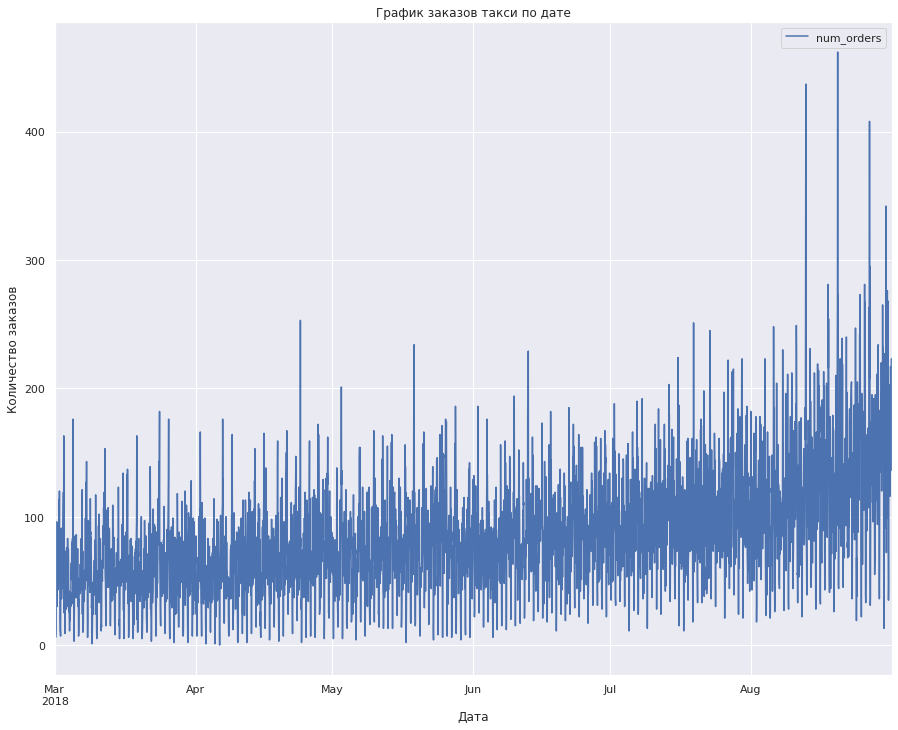

In [7]:
# построим график заказов по часам
df.plot(figsize = (15,12))
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('График заказов такси по дате')
plt.show()

In [8]:
# добавим скользящее среднее
df['rolling_mean'] = df.rolling(24, closed='left').mean()

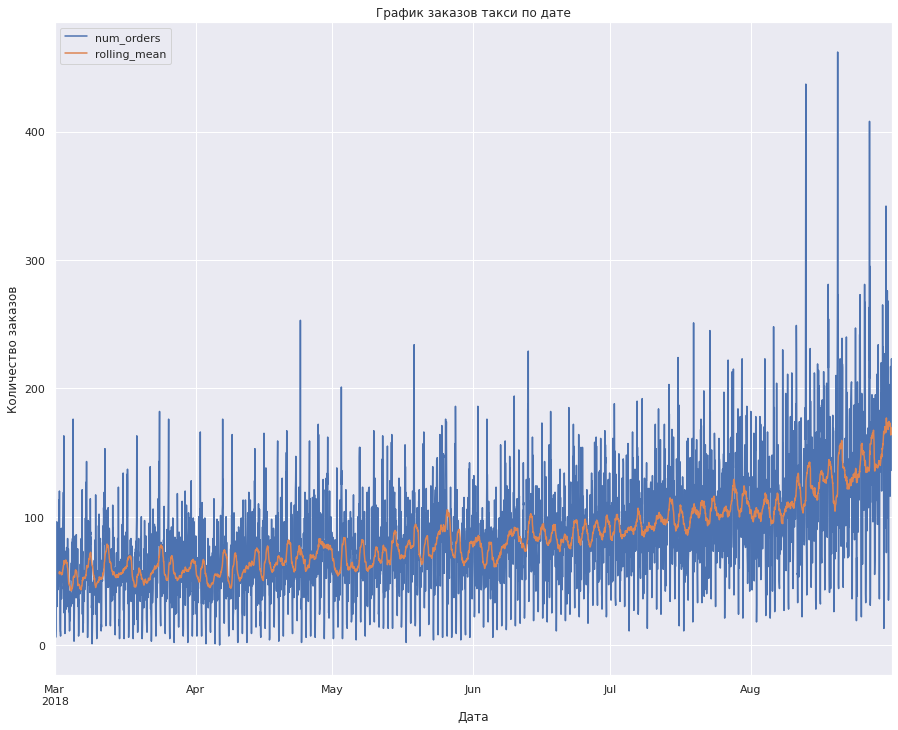

In [9]:
# также построим график
df.plot(figsize = (15,12))
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('График заказов такси по дате')
plt.show()

In [10]:
df = df.drop('rolling_mean', axis=1)

Проверим тест на стационарность при помощи теста Дики-Фуллера.
- Нулевая гипотеза - временной ряд не стационарен
- Альтернативная гипотеза - нулевой ряд стационарен

In [11]:
pvalue = adfuller(df['num_orders'])[1]

alpha = 0.05

In [12]:
for alpha in [0.01, 0.05]:
    if pvalue < alpha:
        print(f'При alpha равному {alpha}:')
        print('P value меньше alpha - отвергаем нулевую гипотезу')
        print(' ')
    else:
        print(f'При alpha равному {alpha}:')
        print('P value не меньше alpha - не можем отвергнуть нулевую гипотезу')
        print(' ')

При alpha равному 0.01:
P value не меньше alpha - не можем отвергнуть нулевую гипотезу
 
При alpha равному 0.05:
P value меньше alpha - отвергаем нулевую гипотезу
 


- По итогу теста Дики-Фуллера вывод неоднозначен: при значении alpha 0.01 мы не можем отвергнуть нулевую гипотезу и считаем, что ряд стационарен. При alpha равному 0.05 мы можем её отвегнуть и считать, что ряд нестационарен.
- Будем считать данный ряд= нестационарным, так как с течением времени у него меняется и среднее, и стандартное отклонение среднего.

In [13]:
# теперь посмотрим на тренд
decomposed = seasonal_decompose(df)

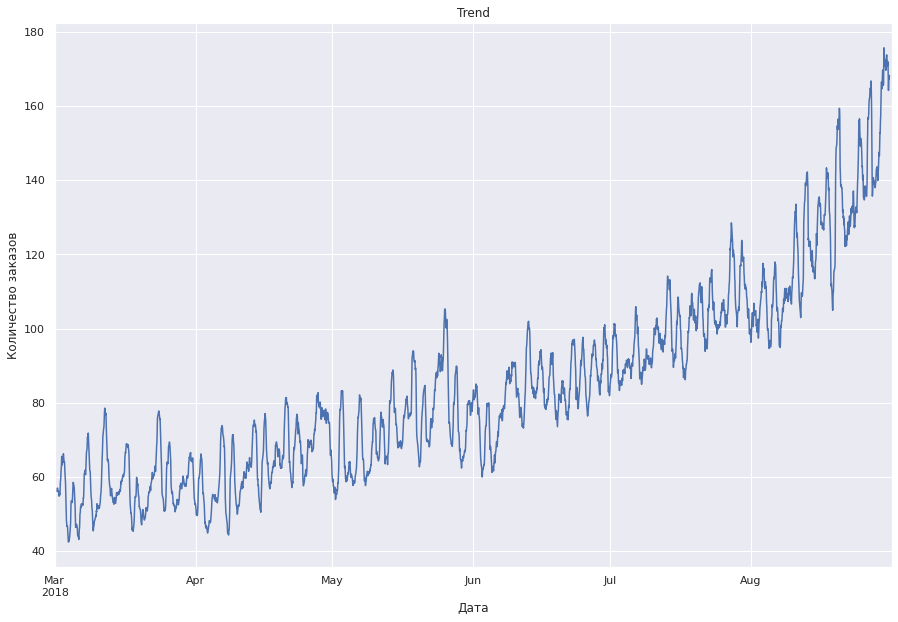

In [14]:
# построим график тренда
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('Trend')
plt.show()

- К концу 2018 года спрос на такси вырос.

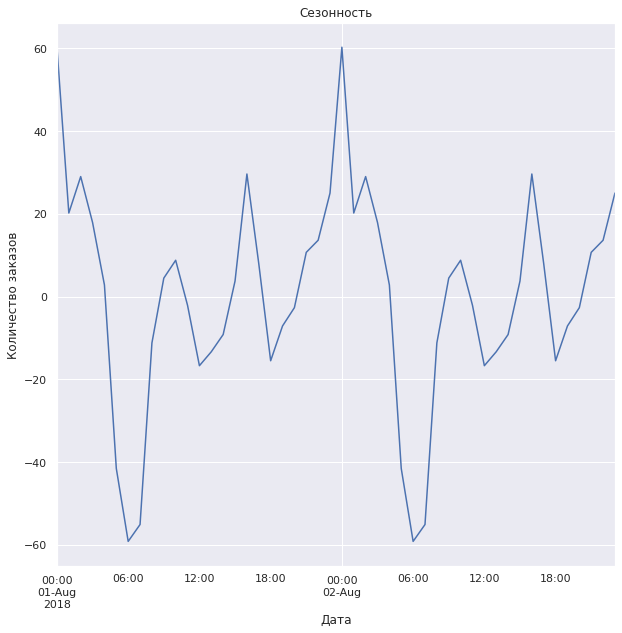

In [15]:
# построим график сезонности за пару дней августа
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca(), figsize=(10, 10))
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('Сезонность')
plt.show()

- Видно, что после 3 часов ночи и до 6 утра идет спад заказов.
- В утренние часы спрос снова возрастает. Вероятно, под утром прилетает большее количество рейсов.
- Максимальное количество заказов наблюдается в период с 21:00 до 03:00. Думаю, это связано с тем, что общественный транспорт уже не работает, либо в данное время не очень много прилетающих самолетов.

## Обучение

### Добавление новых признаков

In [16]:
# создадим функцию для добавления новых признаков признаков
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [17]:
# применим функцию к нашему датасету
df = make_features(df, 24, 24)

In [18]:
df.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Обучение моделей

In [19]:
RANDOM_STATE = 74
tss = TimeSeriesSplit(n_splits=2)

In [20]:
# разобъем данные на тренировочную и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

train = train.dropna()

In [21]:
# проверим, не перемешались ли данные
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [22]:
y_train = train['num_orders']
X_train = train.drop(['num_orders'], axis=1)
y_test = test['num_orders']
X_test = test.drop(['num_orders'], axis=1)

- Разбили данные на тренировочную и тестовую выборки
- Данные не перемешались

In [23]:
# масштабируем данные
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scal, columns=train.drop(['num_orders'], axis=1).columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scal, columns=test.drop(['num_orders'], axis=1).columns, index=X_test.index)

In [24]:
X_train.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,-1.494371,0.48532,-0.527564,0.894187,-0.320444,-0.449344,-0.862885,-0.138173,-0.888716,-0.914359,...,-1.158737,-1.657638,-1.735376,-1.891784,-0.918985,-0.314251,-0.182379,0.186269,1.211966,-1.106319
2018-03-02 01:00:00,-1.494371,0.48532,0.299761,-0.527656,0.895012,-0.319978,-0.448830,-0.862776,-0.138210,-0.888482,...,-0.238042,-1.157864,-1.656492,-1.734086,-1.891348,-0.918758,-0.313858,-0.182033,0.186112,-1.179778
2018-03-02 02:00:00,-1.494371,0.48532,1.075379,0.299598,-0.527331,0.896068,-0.319438,-0.448717,-0.862836,-0.138046,...,-0.369570,-0.237228,-1.156891,-1.655237,-1.733668,-1.891226,-0.918661,-0.313569,-0.182143,-1.104159
2018-03-02 03:00:00,-1.494371,0.48532,-0.088047,1.075149,0.300214,-0.526964,0.896848,-0.319324,-0.448764,-0.862605,...,0.472208,-0.368747,-0.236573,-1.155862,-1.654828,-1.733528,-1.891604,-0.918637,-0.313663,-1.095517
2018-03-02 04:00:00,-1.494371,0.48532,-0.372440,-0.088177,1.076037,0.300982,-0.526465,0.896976,-0.319366,-0.448572,...,-1.263960,0.472977,-0.368047,-0.235961,-1.155506,-1.654679,-1.733829,-1.892006,-0.918654,-1.099838


In [25]:
X_test.head()

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,-0.249587,-1.507418,1.049525,0.351302,1.696696,2.008621,1.517930,0.327644,-1.018113,-0.319186,...,1.050931,1.498829,0.525976,0.105717,0.000818,0.973612,1.973873,1.869935,0.685887,3.130539
2018-08-13 15:00:00,-0.249587,-1.507418,0.610008,1.049298,0.351936,1.698141,2.009620,1.518065,0.327622,-1.017868,...,2.813405,1.051663,1.498883,0.526244,0.105939,0.001144,0.974634,1.975164,1.869565,3.126218
2018-08-13 16:00:00,-0.249587,-1.507418,2.497344,0.609819,1.050177,0.352729,1.699079,2.009760,1.518079,0.327742,...,2.155765,2.814024,1.051871,1.498711,0.526420,0.106276,0.001691,0.975487,1.974781,3.182392
2018-08-13 17:00:00,-0.249587,-1.507418,1.695873,2.496993,0.610543,1.051308,0.353401,1.699216,2.009790,1.518089,...,5.128295,2.156427,2.813622,1.051902,1.498784,0.526803,0.106874,0.002118,0.975231,3.162947
2018-08-13 18:00:00,-0.249587,-1.507418,1.902704,1.695590,2.498380,0.611462,1.052118,0.353523,1.699236,2.009754,...,9.442409,5.128767,2.156252,2.812856,1.052022,1.499271,0.527606,0.107347,0.001984,3.242888


#### LinearRegression

In [26]:
lin_model = LinearRegression()
param_lr = {}

In [27]:
gs_lr = GridSearchCV(
        lin_model,
        param_lr,
        scoring='neg_root_mean_squared_error',
        cv=tss) 

In [28]:
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_root_mean_squared_error')

In [29]:
# замеряем RMSE на кросс-валидации
rmse_lin_model = -(gs_lr.best_score_)

print(f'RMSE для LinearRegression: {rmse_lin_model}')

RMSE для LinearRegression: 28.213811464347604


#### DecisionTreeRegressor

In [30]:
dtr_model = DecisionTreeRegressor(random_state=RANDOM_STATE) 

In [31]:
param_dtr = {"splitter":["best","random"],
             "max_depth" :range(1, 25),
             "min_samples_leaf":range(1,25),
             'min_samples_split':range(2,8,1)}

In [32]:
gs_dtr = GridSearchCV(
         dtr_model,
         param_dtr,
         scoring='neg_root_mean_squared_error',
         cv=tss) 

In [33]:
gs_dtr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=DecisionTreeRegressor(random_state=74),
             param_grid={'max_depth': range(1, 25),
                         'min_samples_leaf': range(1, 25),
                         'min_samples_split': range(2, 8),
                         'splitter': ['best', 'random']},
             scoring='neg_root_mean_squared_error')

In [34]:
# замеряем RMSE на кросс-валидации
rmse_dtr_model = -(gs_dtr.best_score_) 

print(f'RMSE для DecisionTreeRegressor: {rmse_dtr_model}')

RMSE для DecisionTreeRegressor: 31.04507888664034


#### CatBoostRegressor

In [35]:
cat_model = CatBoostRegressor(random_state=RANDOM_STATE, 
                              verbose=False) 

In [36]:
param_cat = {'iterations':[100,200],
             'learning_rate':[0.01,0.02,0.03]}

In [37]:
gs_cat = GridSearchCV(
         cat_model,
         param_cat,
         scoring='neg_root_mean_squared_error',
         cv=tss) 

In [38]:
gs_cat.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f714051e850>,
             param_grid={'iterations': [100, 200],
                         'learning_rate': [0.01, 0.02, 0.03]},
             scoring='neg_root_mean_squared_error')

In [39]:
# замеряем RMSE на кросс-валидации
rmse_cat_model = -(gs_cat.best_score_)

print(f'RMSE для CatBoostRegressor: {rmse_cat_model}')

RMSE для CatBoostRegressor: 28.774552112046102


In [40]:
res = [[rmse_lin_model],
      [rmse_dtr_model],
      [rmse_cat_model]]
model = ["LinearRegressor", "DecisionTreeRegressor", "CatBoostRegressor"]

In [41]:
results = pd.DataFrame(data=res, index=model, columns=[ "RMSE на CV"])

results

,RMSE на CV
LinearRegressor,28.213811
DecisionTreeRegressor,31.045079
CatBoostRegressor,28.774552


### Вывод
- Было обучено 3 регрессионные модели
- Лучше всего себя показала линейная регрессия
- Проведет тестирование данной модели на тестовой выборке и проверим на адекватность

## Тестирование

In [42]:
# проверим лучшую модель на тестовой выборке
pred = gs_lr.best_estimator_.predict(X_test)
print(f'RMSE для линейной регрессии на тестовой выборке: {round(mean_squared_error(y_test, pred) ** 0.5)}')

RMSE для линейной регрессии на тестовой выборке: 45


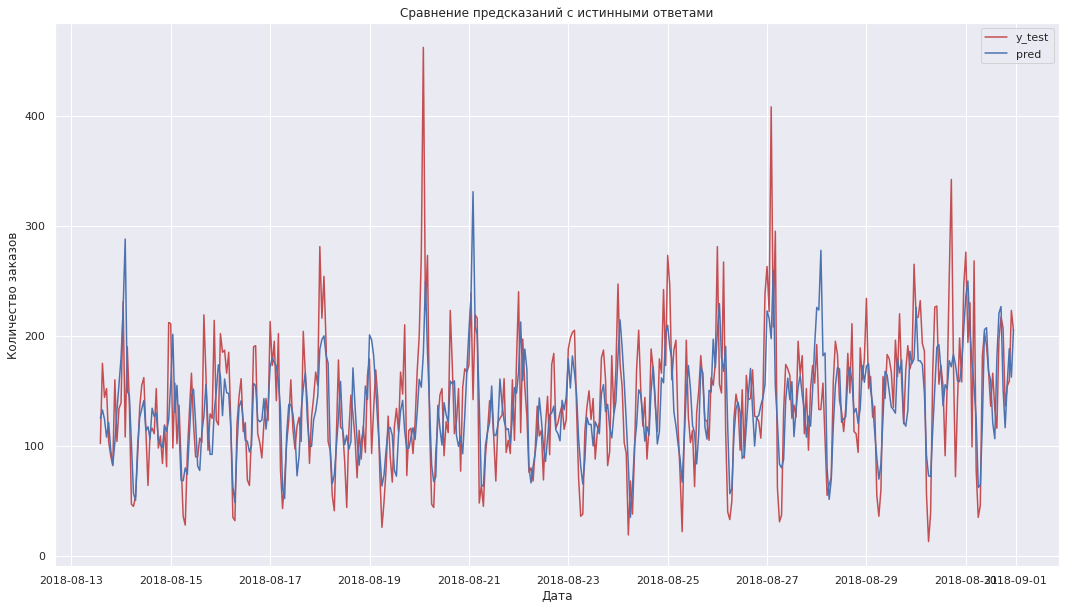

In [43]:
# визуализируем результат
plt.figure(figsize=(18,10))
plt.plot(y_test.index, 
         y_test, 
         'r-', 
         y_test.index, 
         pred,
         'b-')
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title('Сравнение предсказаний с истинными ответами')
plt.legend(labels=['y_test', 'pred'])
plt.show()

- Модель с задачей справилась - RMSE < 48
- По визуализации видно, что модель неплохо улавливает закономерности временного ряда
- Однако, можно заметить, что плохо предсказывает значения, сильно отклрняющиеся от среднего значения, что и логично
- Далее проверим модель на адекватность

In [44]:
model = DummyRegressor(strategy="mean")

In [45]:
model.fit(X_train, y_train)

pred_dummy = model.predict(X_test)

mse_dummy_model = mean_squared_error(y_test, pred_dummy)

print("RMSE для линейной модели:", round((mse_dummy_model) ** 0.5, 2))

RMSE для линейной модели: 84.65


### Заключение
- Модель хорошо показала себя на тестовой выборке, условия заказчика соблюдены
- Модель проверена на адеквартность

## Заключени

- По итогу выполненной работы была выбрана лучшая модель - LinearRegression
- Данная модель имеет лучший показатель метрики (RMSE)
- Остальные модели не подходят под условия заказчика (RMSE > 48)